In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_frame = pd.read_csv("./data/mnist_train.csv", sep=",", header=None)

In [5]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_frame.loc[:, 1:] /= 255.0

In [7]:
data=data_frame.as_matrix()

In [8]:
image=data[0,1:].reshape((28,28))
data[0,0]

5.0

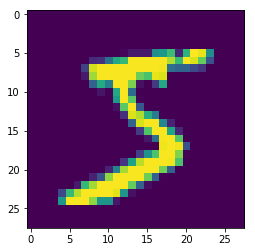

In [9]:
plt.imshow(image)
plt.show()

# Podział na zbiór treningowy i walidacyjny

In [10]:
def create_train_and_val_set(data):
    np.random.shuffle(data)
    train_data=data[0:50000,:]
    val_data=data[50000:,:]
    return train_data, val_data
train_data, val_data = create_train_and_val_set(data)

# Data augmentation

In [11]:
import skimage as sk
from skimage import transform
import random
import scipy
from random import randint

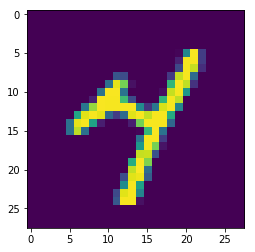

In [72]:
image = train_data[0,1:].copy()
plt.imshow(image.reshape((28,28)))
plt.show()

In [13]:
def rotation (x):
    image=x.reshape(28,28)
    random_degree = random.uniform(-40, 40)
    rotated=sk.transform.rotate(image, random_degree)
    return rotated.reshape(1,784)    

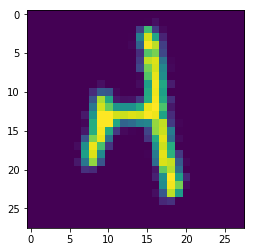

In [14]:
image=data[0,1:].copy()
rotated = rotation(image)
image_rotated=rotated.reshape(28,28)
plt.imshow(image_rotated)
plt.show()

In [15]:
def blurriness_translation (x):
    vector=np.array((random.uniform(-5,5), random.uniform(-5,5)))
    blurrness_ratio=randint(0,5)
    transformed=scipy.ndimage.shift(data[0,1:].reshape(28,28), vector,order=blurrness_ratio,mode='constant')
    return transformed.reshape(1,784)

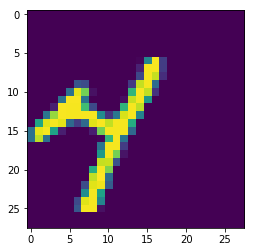

In [16]:
transformed = blurriness_translation(image)
image_transformed=transformed.reshape(28,28)
plt.imshow(image_transformed)
plt.show()

In [17]:
#rescale
def rescale (x):
    x=x.reshape(28,28)
    scale=random.uniform(5,9)/10
    rescaled1=sk.transform.rescale(x, scale, mode='constant', multichannel=False)
    padding_shape=int(np.floor((1-scale)*28/2)+1)
    rescaled_with_padding=np.pad(rescaled1,(padding_shape,padding_shape),mode='constant', constant_values=0)
    transformed=rescaled_with_padding[:28,:28]
    return transformed

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


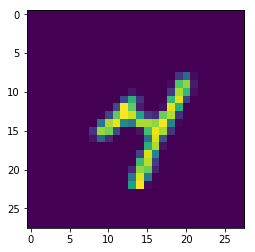

In [18]:
rescaled= rescale(image)
plt.imshow(rescaled)
plt.show()

In [19]:
#ZCA whitening
#https://stackoverflow.com/questions/31528800/how-to-implement-zca-whitening-python


def zca_whitening(x):
    x=x.reshape(1,784)
    sigma = np.dot(x, x.T)/x.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)              #ZCA Whitening matrix
    return np.dot(ZCAMatrix, x)   #Data whitening

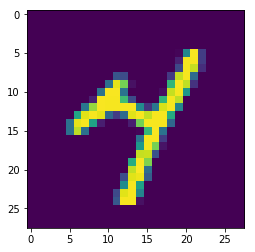

In [20]:
whitened= zca_whitening(image)
plt.imshow(whitened.reshape(28,28))
plt.show()

In [21]:
def random_noise (x):
    noise = np.random.normal(0.0, 0.05, 784) 
    return x+noise

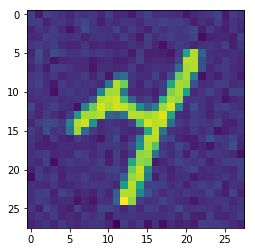

In [22]:
noisy= random_noise(image)
plt.imshow(noisy.reshape(28,28))
plt.show()

In [23]:
#applying modifications to some images
image_transformations = {
    0: rotation,
    1: random_noise,
    2: blurriness_translation,
    3: zca_whitening,
    4: rescale   
}

def apply_image_augmentation(data, n):
    for i in range(n):
        # random num of transformations to apply
        to_apply=np.random.randint(0,2,len(image_transformations))
        input_image=data[i,1:]
        for i in range (len(image_transformations)):
            if to_apply[i]==1:
                input_image=image_transformations[i](input_image) 
                input_image=input_image.reshape(1,784)
        modified=np.insert(input_image, -1,np.array(train_data[i,0]))
        modified=modified.reshape(1,785)
        data=np.append(data, modified,axis=0)   
    return data


# Funkcje aktywacji wraz z ich pochodnymi

In [24]:
def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))

def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def softmax_derivative(probabilities, layer_inputs):
    number_of_classes = probabilities.shape[0]
    diff_output = np.zeros([number_of_classes, number_of_classes])
    for row in range(diff_output.shape[0]):
        for col in range(diff_output.shape[1]):
            if (col == row):
                diff_output[row, col] = probabilities[row, 0] * (1 - probabilities[col, 0])
            else:
                diff_output[row, col] = -probabilities[row, 0] * probabilities[col, 0]
    return np.matmul(diff_output, layer_inputs)

def sigmoid_derivative(u):
    sigmoid_value = sigmoid_function(u)
    diff_output = sigmoid_value * (1 - sigmoid_value)
    return diff_output

def tanh_derivative(u):
    tanh_value = tanh_function(u)
    diff_output = 1 - np.power(tanh_value, 2)
    return diff_output

def tanh_function(x):
    return np.tanh(x)

def relu_function(x):
    return np.maximum(x,0)

def relu_derivative(u):
    relu_value=relu_function(u)
    return (relu_value > 0) * 1


# Funkcje kosztu

In [25]:
def cross_entropy(prediction, target, eps = 1e-12):
    prediction = prediction.T
    target = target.T
    ce = -np.sum(target*np.log(prediction + eps))
    return ce

def mse(predicted, true_label):
    return np.mean(np.square(predicted - true_label))

In [26]:
cross_entropy(np.r_[0,0.8,0.1,0.1].reshape(4,1).T, np.r_[0,1,0,0].reshape(4,1).T)

0.22314355131295974

In [27]:
mse(np.r_[0,0.3,0.3,0.4].reshape(4,1), np.r_[0,1,0,0].reshape(4,1))

0.185

In [28]:
from sklearn.metrics import mean_squared_error, log_loss
mean_squared_error(np.r_[0,0.3,0.3,0.4].reshape(4,1), np.r_[0,1,0,0].reshape(4,1))

0.185

# Implementacja sieci neuronowej

In [29]:
import numpy as np
from random import shuffle
class Network(object):
    
    @staticmethod
    def get_activation_functions_with_deriv():
        return {
            "sigmoid": [sigmoid_function, sigmoid_derivative],
            "tanh": [tanh_function, tanh_derivative], 
            "relu": [relu_function, relu_derivative]
        }
    
    @staticmethod
    def get_error_functions():
        return {
            "mse": mse,
            "cross_entropy": cross_entropy
        }
    
    @staticmethod
    def get_cost_functions():
        return {
            "mse": lambda outputs, inputs, labels, deriv: (outputs - labels) * \
                                                           deriv(outputs, inputs),
            "cross_entropy": lambda outputs, inputs, labels, deriv: outputs - labels
        }
    
    def __init__(self,
                 input_neurons_num,
                 hidden_layer_neurons_num,
                 hidden_activation_functions_names,
                 learning_rate=0.04,weight_decay=0.005, momentum=0.9,
                 error_function_name="cross_entropy", regularization=True, momentum_presence=True):
        self.input_neurons_num = input_neurons_num
        self.number_of_classes = 10
        self.learning_rate = learning_rate
        self.weight_decay=weight_decay
        self.momentum=momentum
        self.regularization=regularization
        self.momentum_presence=momentum_presence
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = self.__get_activation_functions(hidden_activation_functions_names)
        self.activation_deriv_functions = self.__get_deriv_activation_functions(hidden_activation_functions_names)
        self.error_function = Network.get_error_functions()[error_function_name]
        self.cost_function = Network.get_cost_functions()[error_function_name]
        self.weight_list = Network.__get_weight_list(self.neurons_num_per_layer)
        self.bias_list = Network.__get_bias_list(self.neurons_num_per_layer)

    def __get_deriv_activation_functions(self, inner_activation_functions_names):
        functions = Network.__transform_to_activation_func_with_deriv(inner_activation_functions_names)
        return list(map(lambda x: x[1], functions)) + \
            [lambda prob, layer_inputs: softmax_derivative(probabilities=prob, layer_inputs=layer_inputs)]
    
    def __get_activation_functions(self, inner_activation_functions_names):
        functions = Network.__transform_to_activation_func_with_deriv(inner_activation_functions_names)
        return list(map(lambda x: x[0], functions)) + \
            [lambda x: softmax_function(x)]
    
    @staticmethod
    def __transform_to_activation_func_with_deriv(inner_activation_functions_names):
        functions = Network.get_activation_functions_with_deriv()
        return map(lambda name: functions[name], inner_activation_functions_names)
        
    @staticmethod
    def __get_bias_list(neurons_num_per_layer):
        return [np.random.randn(layer_num, 1) for layer_num in neurons_num_per_layer[1:]]

    @staticmethod
    def __get_weight_list(neurons_num_per_layer):
        # Xavier initialization
        return [np.random.randn(next_layer_num, current_layer_num) *
                np.sqrt(6 / (next_layer_num + current_layer_num))
                for (current_layer_num, next_layer_num) in zip(neurons_num_per_layer, neurons_num_per_layer[1:])]

    def train(self, train_data, val_data, train_batch_size, epochs):
        train_avg_per_epoch = np.zeros(epochs)
        val_avg_per_epoch = np.zeros(epochs)
        for epoch in range(epochs):
            np.random.shuffle(train_data)
            train_batches = Network.__create_batches(train_data, train_batch_size)
            train_cost = self.__train_one_epoch(train_batches)
            train_avg_per_epoch[epoch] = train_cost/ train_data.shape[0]
            _, val_cost= self.predict(val_data, False)
            val_avg_per_epoch[epoch] = val_cost / val_data.shape[0]
        return train_avg_per_epoch, val_avg_per_epoch

    def predict(self, test_data, with_stat):
        labels = Network.one_hot_encoded(test_data[:, 0], self.number_of_classes)
        features = test_data[:, 1:]
        res = []
        diff = 0
        stat = np.zeros((test_data.shape[0], 2)) if with_stat else None
        for i in range(len(test_data)):
            _, layer_output_list = self.__feed_forward(features[i, :])
            output = layer_output_list[-1]
            if with_stat:
                stat[i, 0] = np.argmax(output)
                stat[i, 1] = np.argmax(labels[:, i])    
            diff += self.error_function(output, labels[:, i])
        return stat, diff
    
    def __train_one_epoch(self, train_batches):
        full_cost = 0
        grad_w_prev = [0] * (self.layers_num - 1)
        for train_batch in train_batches:
            labels = Network.one_hot_encoded(train_batch[:, 0], self.number_of_classes)
            train_batch_features = train_batch[:, 1:]
            batch_size = train_batch_features.shape[0]
            grad_b, grad_w, cost = self.__get_gradients(labels, train_batch, train_batch_features)
            full_cost += cost
            self.__update_network_params(batch_size, grad_b, grad_w, grad_w_prev)
        return full_cost

    def __update_network_params(self, batch_size, grad_b, grad_w, grad_w_prev):
        if (self.momentum_presence==True):
                momentum_term_w = [ self.momentum*w_prev/self.learning_rate for w_prev in grad_w_prev]
                grad_w=[a+b for a, b in zip(grad_w,momentum_term_w)]
                
        self.weight_list = [w - (self.learning_rate * gw / batch_size)
                            for w, gw in zip(self.weight_list, grad_w)]
        self.bias_list = [b - (self.learning_rate * gb / batch_size)
                          for b, gb in zip(self.bias_list, grad_b)]

    def __get_gradients(self, labels, train_batch, train_batch_features):
        cost = 0
        grad_w = [0] * (self.layers_num - 1)
        grad_b = [0] * (self.layers_num - 1)
        for i in range(len(train_batch)):  # rekord
            layer_inputs, layer_outputs = self.__feed_forward(train_batch_features[i, :])
            cost += self.error_function(layer_outputs[-1], labels[:, i].reshape(self.number_of_classes, -1))
           
            # backprop
            delta = self.__get_deltas(labels[:, i], layer_inputs, layer_outputs)
            one_grad_w = [np.matmul(delta[0], train_batch_features[i, :].reshape(self.input_neurons_num, -1).T)]
            for activ, d, u in zip(self.activation_functions, delta[1:], layer_inputs):
                one_grad_w.append(np.matmul(d, activ(u).T))

            grad_w = [a + b for a, b in zip(grad_w, one_grad_w)]
            grad_b = [a + b for a, b in zip(delta, grad_b)]
            
            if (self.regularization==True):
                regularization_term = [ self.weight_decay*w for w in self.weight_list]
                grad_w=[a+b for a, b in zip(grad_w,regularization_term)]
        return grad_b, grad_w, cost

    def __get_deltas(self, labels, layer_inputs, layer_outputs):
        labels = labels.reshape(self.number_of_classes, -1)
        delta = [self.cost_function(layer_outputs[-1],
                                    layer_inputs[-1],
                                    labels, 
                                    self.activation_deriv_functions[-1])]
        for layer_num in reversed(range(1, self.layers_num - 1)):
            delta.append(np.matmul(self.weight_list[layer_num].T, delta[-1]) *
                         self.activation_deriv_functions[layer_num - 1](layer_inputs[layer_num - 1]))
        delta = list(reversed(delta))
        return delta

    def __feed_forward(self, features):
        layer_inputs = []
        layer_output = [features]
        for activation_function, w, b in zip(self.activation_functions,
                                             self.weight_list,
                                             self.bias_list):
            a = np.matmul(w, layer_output[-1])
            layer_inputs.append(a.reshape(a.shape[0], 1) + b)
            layer_output.append(activation_function(layer_inputs[-1]))
        return layer_inputs, layer_output

    @staticmethod
    def __create_batches(data, batch_size):
        rows_num = data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]

    @staticmethod
    def one_hot_encoded(labels, number_of_classes):
        labels = labels.astype(int)
        res = np.zeros((number_of_classes, labels.shape[0]))
        res[labels, np.arange(res.shape[1])] = 1
        return res

# Testowanie implementacji

## Setup

### Wczytanie danych testowych

In [30]:
test_data = pd.read_csv("./data/mnist_test.csv", sep=",", header=None)
test_data.loc[:, 1:] /= 255.0
test_data=test_data.as_matrix()

### Metryki

In [31]:
def compute_accurracy(stat):
    count=0
    for i in range (stat.shape[0]):
        if stat[i,0]==stat[i,1]:
            count=count+1
    return count/stat.shape[0]

### Zapisywanie wyników

In [32]:
import json
def save_as_json(v, file_name):
    output = []
    for i in range(len(v)):
        element = v[i]
        element["df_wrong_predicted"] = element["df_wrong_predicted"].index.tolist()
        element["stat"] = element["stat"].tolist()
        element["train_cost"] = element["train_cost"].tolist()
        element["val_cost"] = element["val_cost"].tolist()
        output.append(element)
    with open(file_name, "w") as f:
        f.write(json.dumps(output))

### Wizualizacja

In [33]:
def show_error_plot(train_cost, val_cost):
    plt.plot(train_cost, label = "train")
    plt.plot(val_cost, label = "val")
    plt.legend(loc = "upper right")
    plt.show()

## Testy

In [34]:
def test(train_data, val_data, test_data, hidden_layer_neurons_num, hidden_activation_functions_names,
         epochs,
         image_augmentation,
         train_batch_size=128,
         learning_rate=0.04,
         weight_decay=0.005,
         momentum=0.9,
         error_function_name="cross_entropy",
         regularization=False,
         momentum_presence=False,
         images_to_transform_num=1000):
    
    train_data = train_data.copy()
    val_data = val_data.copy()
    
    if image_augmentation:
        apply_image_augmentation(train_data, images_to_transform_num)
        
    net = Network(input_neurons_num=784,
                  hidden_layer_neurons_num=hidden_layer_neurons_num,
                  hidden_activation_functions_names=hidden_activation_functions_names,
                  learning_rate=learning_rate,
                  weight_decay=weight_decay,
                  momentum=momentum,
                  error_function_name=error_function_name,
                  regularization=regularization,
                  momentum_presence=momentum_presence)
    train_cost, val_cost = net.train(train_data, val_data, train_batch_size=train_batch_size, epochs=epochs)
    stat, test_error = net.predict(test_data, with_stat=True)
    df_stat = pd.DataFrame({"predicted": stat[:,0], "wanted": stat[:, 1]}).astype(int)
    df_wrong_predicted = df_stat.loc[df_stat["predicted"] != df_stat["wanted"]]
    accuracy = compute_accurracy(stat)
    
    print("accuracy {0}".format(accuracy))
    show_error_plot(train_cost, val_cost)
    
    return {
        "train_cost": train_cost,
        "val_cost": val_cost,
        "df_wrong_predicted": df_wrong_predicted,
        "accuracy": accuracy,
        "hidden_layer_neurons_num": hidden_layer_neurons_num,
        "hidden_activation_functions_names": hidden_activation_functions_names,
        "epochs": epochs,
        "train_batch_size": train_batch_size,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "momentum": momentum,
        "error_function_name": error_function_name,
        "regularization": regularization,
        "momentum_presence": momentum_presence,
        "image_augmentation": image_augmentation,
        "stat": stat,
        "test_error": test_error
    }

### Przypadki testowe

In [35]:
results = []

accuracy 0.9695


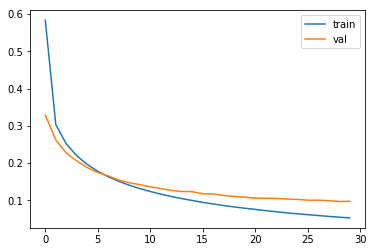

In [36]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=30,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.9715


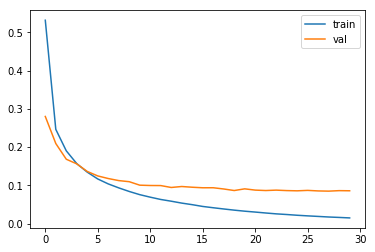

In [37]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 4,
    hidden_activation_functions_names=["tanh"] * 4,
    epochs=30,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.9504


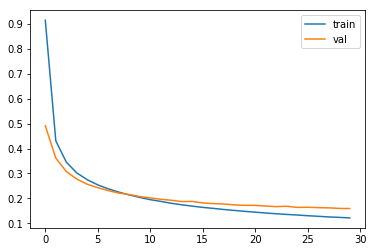

In [38]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[20] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=30,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.9498


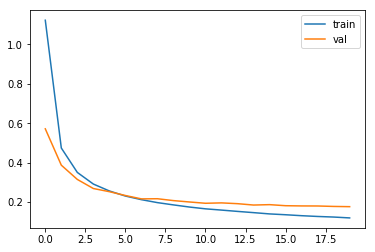

In [39]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[20] * 5,
    hidden_activation_functions_names=["tanh"] * 5,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.9681


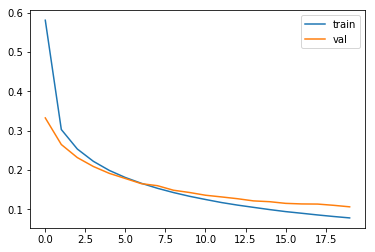

In [40]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.9519


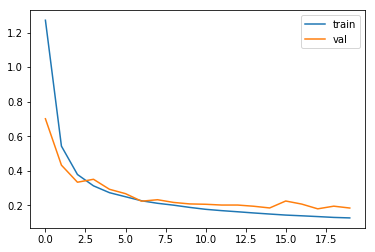

In [41]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[20] * 10,
    hidden_activation_functions_names=["tanh"] * 10,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.9368


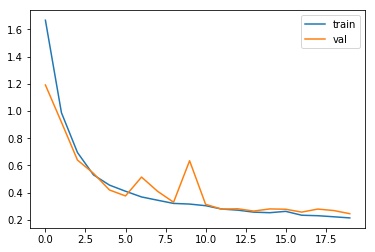

In [42]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[20] * 20,
    hidden_activation_functions_names=["tanh"] * 20,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

accuracy 0.211


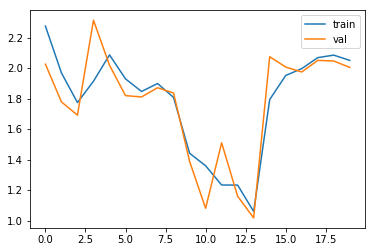

In [43]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[20] * 30,
    hidden_activation_functions_names=["tanh"] * 30,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.951


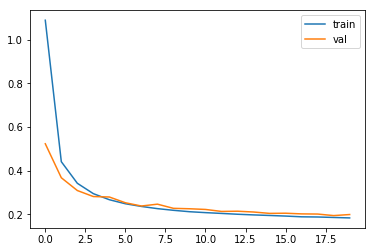

In [44]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[20] * 5,
    hidden_activation_functions_names=["tanh"] * 5,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True,
    regularization=True,
    momentum_presence=True)
results.append(r)

accuracy 0.3596


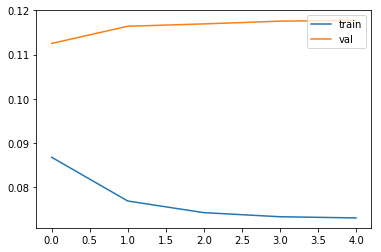

In [45]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=5,
    error_function_name="mse",
    image_augmentation=False)
results.append(r)

accuracy 0.9571


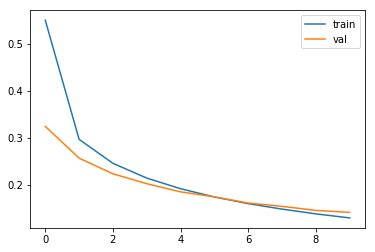

In [46]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=10,
    error_function_name="cross_entropy",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.8842


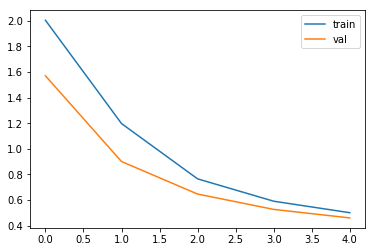

In [47]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["sigmoid"] * 2,
    epochs=5,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.9686


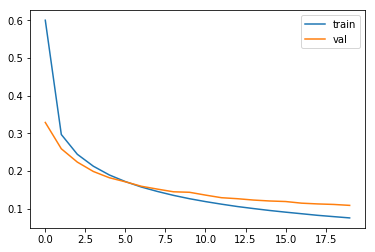

In [48]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9659


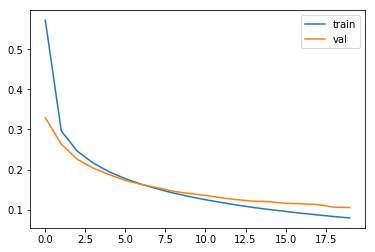

In [49]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.9205


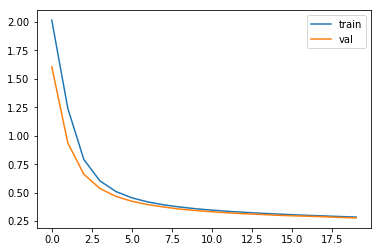

In [50]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["sigmoid"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.922


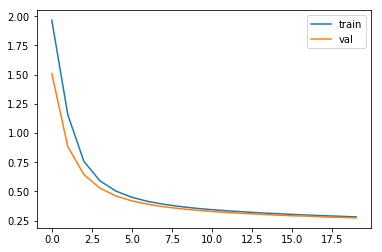

In [51]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["sigmoid"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.9701


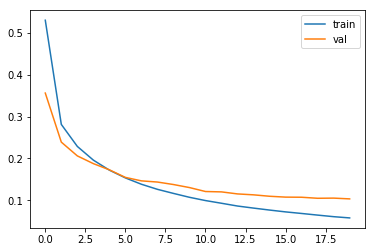

In [52]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["relu"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9684


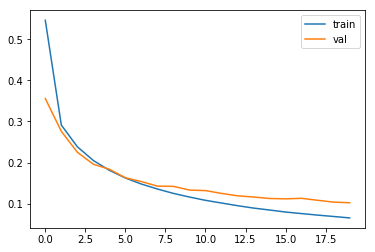

In [53]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["relu"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.9579


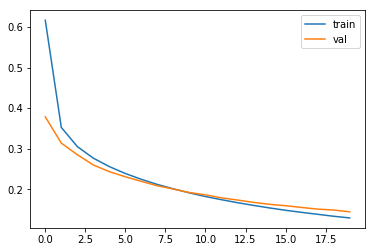

In [54]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 1,
    hidden_activation_functions_names=["tanh"] * 1,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.96


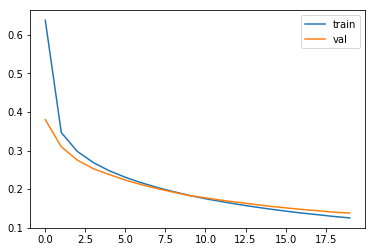

In [55]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 1,
    hidden_activation_functions_names=["tanh"] * 1,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.9692


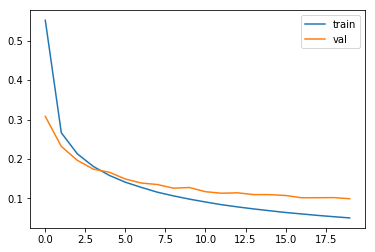

In [56]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 3,
    hidden_activation_functions_names=["tanh"] * 3,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9727


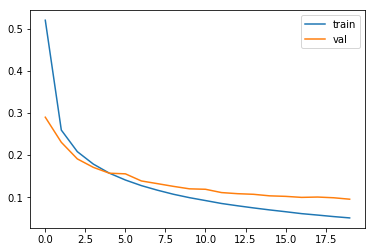

In [57]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 3,
    hidden_activation_functions_names=["tanh"] * 3,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.3387


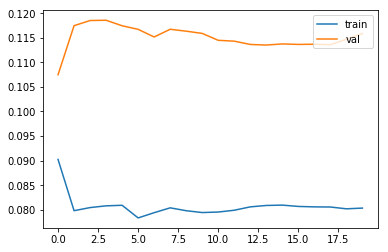

In [58]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="mse",
    image_augmentation=False)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.2888


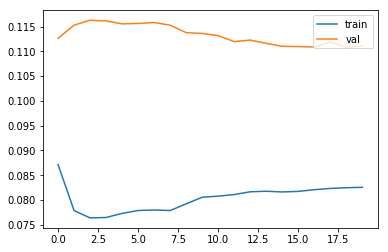

In [59]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="mse",
    image_augmentation=True)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9666


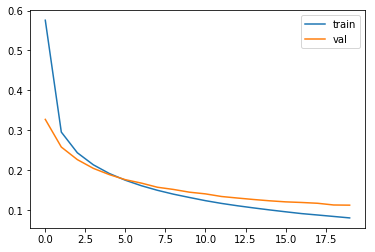

In [60]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

accuracy 0.9514


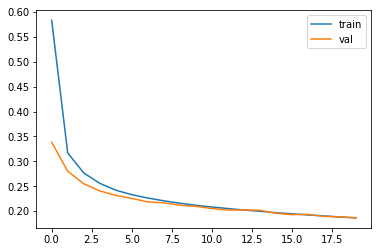

In [62]:
r = test(train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=True)
results.append(r)

accuracy 0.9682


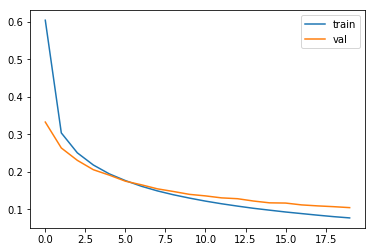

In [63]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9536


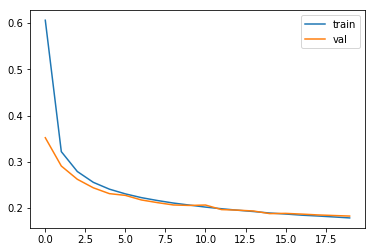

In [64]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True,
    regularization=True,
    momentum_presence=True)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9592


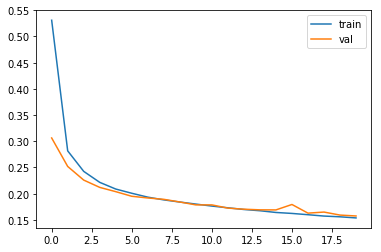

In [65]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 3,
    hidden_activation_functions_names=["tanh"] * 3,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True,
    regularization=True,
    momentum_presence=True)
results.append(r)

accuracy 0.3167


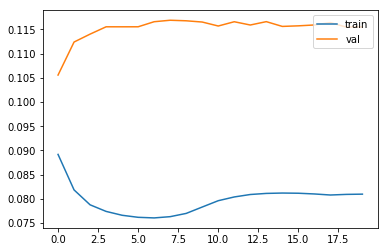

In [66]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["tanh"] * 2,
    epochs=20,
    error_function_name="mse",
    image_augmentation=False,
    regularization=False,
    momentum_presence=True)
results.append(r)

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9744


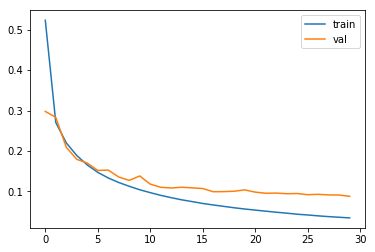

In [67]:
r = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128] * 2,
    hidden_activation_functions_names=["relu"] * 2,
    epochs=30,
    error_function_name="cross_entropy",
    image_augmentation=True)
results.append(r)

In [68]:
save_as_json(results, "final_test_results.json")

/home/slowik/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


accuracy 0.9665


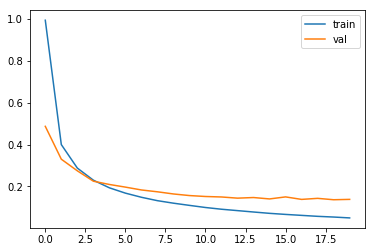

In [69]:
ttt = test(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    hidden_layer_neurons_num=[128, 64, 32, 16, 8],
    hidden_activation_functions_names=["tanh"] * 5,
    epochs=20,
    error_function_name="cross_entropy",
    image_augmentation=True)
save_as_json([ttt], "different_layer_sizes.json")

In [70]:
len(test_data)

10000